<a href="https://colab.research.google.com/github/abhijain864/Summer_Project_2020/blob/main/Summer_project_2(_random_similarity).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing libraries
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.linear_model import Ridge
from numpy import random

In [ ]:
# Importing libraries
import os
import re

#Extracting images from the zipped file
import requests, zipfile, io
r = requests.get('https://github.com/jcpeterson/percept2vec/blob/master/animals.zip?raw=true') 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

## Extracting features

In [ ]:
# Pretrained VGG model
pretrained_model = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
pretrained_model.trainable = False

preprocess = tf.keras.applications.vgg16.preprocess_input
decode_pred = tf.keras.applications.vgg16.decode_predictions

553467904/553467096 [==============================] - 13s 0us/step


In [ ]:
# Loading Image data
img_data = np.zeros((1, 224, 224, 3))
filenames = os.listdir('images')
filenames.remove('desktop.ini')

# Sorting the filenames
img_no = [re.findall(r'\d+', filename)[0] for filename in filenames]
img_no.sort()
sorted_filenames = ['stim-' + no +'.png' for no in img_no]

for filename in sorted_filenames:
  path = 'images/' + filename
  img = load_img(path, target_size=(224, 224))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess(img)
  img_data = np.append(img_data, img, axis = 0)
  
img_data = np.delete(img_data, 0, 0)
print(img_data.shape)

(120, 224, 224, 3)


In [ ]:
# Features extractor
feature_extractor = tf.keras.models.Model(inputs = pretrained_model.input, outputs = pretrained_model.layers[-2].output)
feature_matrix = feature_extractor.predict(img_data)
print(feature_matrix.shape)

(120, 4096)


## Adapting features

In [ ]:
# Generate X matrix for regression
def random_similarity(N, seed=None):
  random.seed(seed)
  A = random.rand(N, N)
  smatrix = (A + A.T)/2
  smatrix = smatrix*10
  smatrix = np.around(smatrix, decimals=1)

  return smatrix

def generate_X_matrix(Fmatrix):
  N = Fmatrix.shape[0]
  ind = np.triu_indices(N)
  n = len(ind[0])

  X = np.zeros((n, Fmatrix.shape[1]))
  for i in np.arange(0, n):
    k = ind[0][i]
    l = ind[1][i]
    X[i] = Fmatrix[k]*Fmatrix[l]   

  return X

# Running a ridge regression to adapt features to  a target similarity matrix
def adapt_features(fmatrix, target_matrix):
  X = generate_X_matrix(fmatrix)
  y = target_matrix[np.triu_indices_from(target_matrix)]
  reg = Ridge(alpha = 1.0, fit_intercept=False, solver='sag')
  reg.fit(X, y)
  w = reg.coef_
  s = reg.score(X, y)

  return reg, w, s

In [ ]:
scores = []
seed = list(range(100,125))

In [ ]:
print("Score appended for:", end=" ")
for i in range(25):
  smatrix = random_similarity(120, seed[i])
  _, _, score = adapt_features(feature_matrix, smatrix)
  scores.append(score)
  print(i, end=" ")

Score appended for: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [ ]:
scores

[0.2188424601641633,
 0.21316839589801995,
 0.18661096524529674,
 0.17392516188923435,
 0.19402363309170734,
 0.19576661526226669,
 0.17224823822476742,
 0.20251656951018215,
 0.21106655281674735,
 0.20838670035528184,
 0.18599369467331728,
 0.19728319884524914,
 0.21340749231834344,
 0.18358611409526038,
 0.18690892841769802,
 0.20700189310178418,
 0.16744708234312589,
 0.20321197160323778,
 0.19967883912672324,
 0.21743255168273934,
 0.21895403039676786,
 0.15477618951609995,
 0.18769404001499534,
 0.17279029654521272,
 0.20172218051336388]

In [ ]:
np.asarray(scores).mean()

0.1949777518260634

## Adapting on random image data

In [ ]:
# Getting human similarity data

from scipy.io import loadmat

!wget https://github.com/jcpeterson/percept2vec/blob/master/turkResults_CogSci2016.mat?raw=true
!mv turkResults_CogSci2016.mat\?raw\=true human_data.mat

human_data = loadmat('human_data.mat')
human_sim_matrix = human_data['simMatrix']

--2020-07-16 07:49:23--  https://github.com/jcpeterson/percept2vec/blob/master/turkResults_CogSci2016.mat?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jcpeterson/percept2vec/raw/master/turkResults_CogSci2016.mat [following]
--2020-07-16 07:49:23--  https://github.com/jcpeterson/percept2vec/raw/master/turkResults_CogSci2016.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jcpeterson/percept2vec/master/turkResults_CogSci2016.mat [following]
--2020-07-16 07:49:24--  https://raw.githubusercontent.com/jcpeterson/percept2vec/master/turkResults_CogSci2016.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [ ]:
def random_imgdata(N, shape, seed = None):
  rand_imgs = np.zeros(shape = (1,) + shape)

  for i in range(N):
    img = random.uniform(0, 1, size = shape)
    img = np.around(256*img)
    img = np.expand_dims(img, axis=0)
    img = preprocess(img)
    rand_imgs = np.append(rand_imgs, img, axis = 0)

  rand_imgs = np.delete(rand_imgs, 0, 0)  
  return rand_imgs

In [ ]:
scores = []

In [ ]:
print("Score appended for:", end=" ")
for i in range(25):
  fmatrix = feature_extractor.predict(random_imgdata(120, shape=(224, 224, 3)))
  _, _, score = adapt_features(fmatrix, human_sim_matrix)
  scores.append(score)
  print(i, end=" ")

Score appended for: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [ ]:
scores

[0.2756763877413375,
 0.2735207589869426,
 0.23746527853829977,
 0.25742544960009095,
 0.2726489845686333,
 0.26648012566275425,
 0.2617754688008215,
 0.2531037069972273,
 0.2703234540247603,
 0.26143316544758555,
 0.26435757179242303,
 0.27784277630983345,
 0.277991648212771,
 0.2751375728928711,
 0.26136344445003457,
 0.26228082404264763,
 0.24804219940734884,
 0.2532622302914902,
 0.2773887898401737,
 0.26430745941275036,
 0.24376913973416225,
 0.263216108804192,
 0.2724182928951323,
 0.25408030312278673,
 0.26724339201517067]

In [ ]:
np.asarray(scores).mean()

0.26370218134368967

## Adapting random features

In [ ]:
scores = []

In [ ]:
print("Score appended for:", end=" ")
for i in range(25):
  fmatrix = random.normal(0, 1, size = (120, 4096))
  _, _, score = adapt_features(fmatrix, human_sim_matrix)
  scores.append(score)
  print(i, end=" ")

Score appended for: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [ ]:
scores

[0.32599751557713585,
 0.32736907490273304,
 0.30045543184308,
 0.31459631725750103,
 0.3110552303989079,
 0.31342535996177434,
 0.30074765815214743,
 0.31004120583401074,
 0.2936537680126641,
 0.30468284167129633,
 0.304739343485261,
 0.2948081979757403,
 0.2828257146381582,
 0.31579792425400266,
 0.30922418587920386,
 0.2761427542622714,
 0.34195056780674504,
 0.3100399102103546,
 0.2807684016891736,
 0.3006437437280862,
 0.3163332007284576,
 0.31474858517809023,
 0.2958133625753422,
 0.319855202944218,
 0.33074491731365185]

In [ ]:
np.asarray(scores).mean()

0.3023561187082324

## Appendix

### Visualizing a randomly generated image data

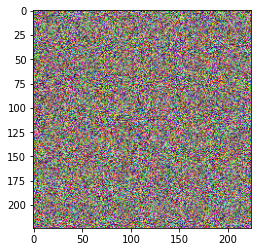

In [ ]:
x = random_imgdata(1, shape = (224, 224, 3))
x = np.squeeze(x, axis = 0)
x = array_to_img(x)
plt.figure()
plt.imshow(x)

### Visualizing adversarial perturbations

In [ ]:
# Generate integer labels from model output
def get_int_label(probs):
  labels = np.argmax(probs, axis = 1)
  return labels

# Generate one_hot_labels from labels
def get_one_hot_label(labels):
  one_hot_label = tf.keras.utils.to_categorical(labels, num_classes=1000)
  return one_hot_label

In [ ]:
img_probs = pretrained_model.predict(img_data)
true_labels = get_int_label(img_probs)
one_hot_labels = get_one_hot_label(true_labels)

In [ ]:
def perturbation_generator(input_image, input_label, loss_object):
  if loss_object is None:
    loss_object = tf.keras.losses.CategoricalCrossentropy()
  else:
    loss_object = tf.keras.losses.get(loss_object)

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)   # Get the gradients of the loss w.r.t to the input image.
  signed_grad = tf.sign(gradient)   # Get the sign of the gradients to create the perturbation

  return signed_grad

# Generate adversarial image data for all images
def adversarial_imageset_generator(eps, data = img_data, labels = one_hot_labels, loss = None):
  perturbed_imgs = np.zeros_like(img_data)

  for i in range(len(perturbed_imgs)):
    image = np.expand_dims(data[i], axis=0)
    image = tf.convert_to_tensor(image)
    label = np.expand_dims(labels[i], axis = 0)
    label = tf.convert_to_tensor(label)
    
    perturbation = perturbation_generator(image, label, loss)
    adv_img = image + eps*perturbation
    perturbed_imgs[i] = adv_img[0]

  return perturbed_imgs


In [ ]:
epsilon = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 10.0, 15.0, 20.0]
i = random.choice(120, 1)[0]

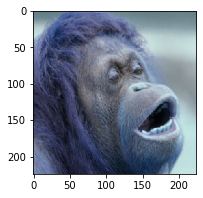

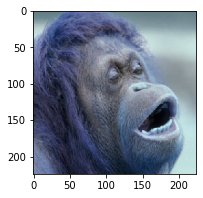

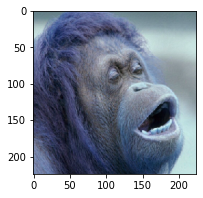

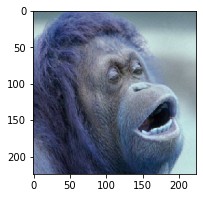

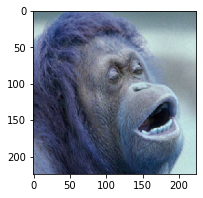

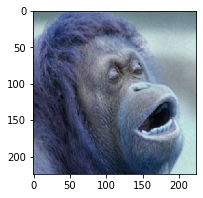

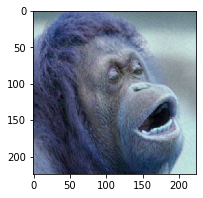

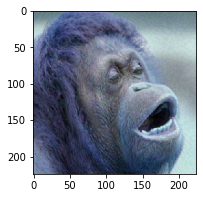

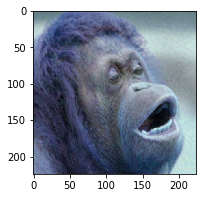

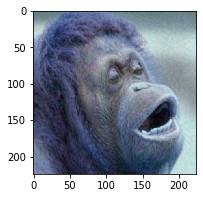

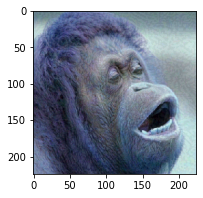

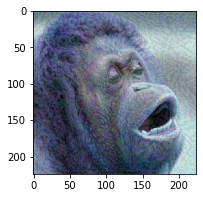

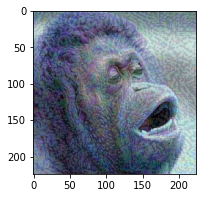

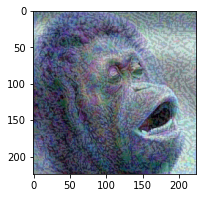

In [ ]:
for eps in epsilon:
  image = np.expand_dims(img_data[i], axis=0)
  image = tf.convert_to_tensor(image)
  label = np.expand_dims(one_hot_labels[i], axis = 0)
  label = tf.convert_to_tensor(label)

  perturbation = perturbation_generator(image, label, loss_object = 'categorical_crossentropy')
  adv_img = image + eps*perturbation

  adv_img = np.squeeze(adv_img, axis = 0)
  adv_img = array_to_img(adv_img)

  fig, ax = plt.subplots(1, 1, figsize = [3, 3])
  ax.imshow(adv_img)
  fig.show